In [1]:
import json
import os
import numpy as np
import pandas as pd
from scipy.interpolate import griddata, RBFInterpolator
from scipy import optimize
from bmn.brezin import compute_Brezin_energy
from scipy import interpolate, integrate

import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 5.0
plt.rcParams["xtick.minor.size"] = 3.0
plt.rcParams["ytick.major.size"] = 5.0
plt.rcParams["ytick.minor.size"] = 3.0
plt.rcParams["lines.linewidth"] = 2
plt.rc("font", family="serif", size=16)
matplotlib.rc("text", usetex=True)
matplotlib.rc("legend", fontsize=16)
matplotlib.rcParams["axes.prop_cycle"] = cycler(
    #color=["#E24A33", "#348ABD", "#988ED5", "#777777", "#FBC15E", "#8EBA42", "#FFB5B8"]
    color=['#9e0142','#d53e4f','#f46d43','#fdae61','#fee08b','#e6f598','#abdda4','#66c2a5','#3288bd','#5e4fa2'][::-1]
)
matplotlib.rcParams.update(
    {"axes.grid": False, "grid.alpha": 0.75, "grid.linewidth": 0.5}
)
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

np.set_printoptions(linewidth=160)

In [2]:
def load_data(
        datadir,
        names_in_filename,
        tol=1e-6,
        delete_param=True
        ):

    # grab the data files
    names_in_filename.append('.json')
    files = []
    for f in os.listdir(datadir):
        if all(name in f for name in names_in_filename):
            files.append(f)
    print(f"number of files found: {len(files)}")

    if len(files) == 0:
        return

    # build dataframe
    data = []
    for file in files:
        with open(f"{datadir}/{file}") as f:
            result = json.load(f)
        if delete_param:
            del result["param"] # remove param vector
        #result["energy"] = float(file.split('_')[1][:-5]) # add g4 coupling
        result["filename"] = file

        if (
            (np.abs(result["min_bootstrap_eigenvalue"]) < tol) &
            (np.abs(result["violation_of_linear_constraints"]) < tol) &
            (np.abs(result["quad_constraint_violation_norm"]) < tol)
        ):
            data.append(result)

    df = pd.DataFrame(data)
    if len(df) == 0:
        return df.copy()

    df.sort_values("energy", inplace=True)
    max_violation_linear = df["violation_of_linear_constraints"].max()
    max_violation_quadratic = df["max_quad_constraint_violation"].max()
    max_violation_PSD = df["min_bootstrap_eigenvalue"].abs().max()

    print(f"number of loaded data points: {len(data)}")
    print(f"max violation of linear constraints:{max_violation_linear:.4e}")
    print(f"max violation of PSD constraints:{max_violation_PSD:.4e}")
    print(f"max violation of quadratic constraints:{max_violation_quadratic:.4e}\n")

    return df.copy()


def Morita_R_squared(d, loop):
    if loop == 2:
        return d / (2 * (d-1)**(1/3))
    elif loop == 3:
        return (d * (148*d - 103)) / (15 * 30**(1/3) * (4*d - 3)**(4/3))


def get_beta_from_E_and_F(energy, free_energy):
    free_energy_interp = interpolate.UnivariateSpline(energy, free_energy)
    dF_by_dE = free_energy_interp.derivative(n=1)
    dF_by_dE = dF_by_dE(energy)
    beta = np.exp(integrate.cumulative_trapezoid(dF_by_dE / (energy - free_energy), energy, initial=0))
    return beta


def lin_lower_bound_x2(energy: float) -> float:
    # eq 2.18 and 2.19 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # v is an auxiliary variable
    eq2_19 = lambda v: energy**2 + 3**9 / (energy + 3 * v) - 9 * v**2
    sol = optimize.root(eq2_19, [0])
    v = sol.x.item()
    lower_bound = (energy - 3*v)**2 / (9**3 * 16) + 27 / (8 * (energy + 3 * v))
    return lower_bound


def lin_lower_bound_x4_bosonic_only(energy: float, d: int) -> float:
    return energy / (3 * d * (d-1))


def lin_lower_bound_x4_initial(energy: float, d: int) -> float:
    # eq 2.13 of https://doi.org/10.1007/JHEP06(2023)038
    # includes fermions in how the virial theorem is used
    # y is the bound
    eq2_13 = lambda y: np.sqrt(y) * (2*d*(d-1) * y + 2/3*energy) - d/4
    sol = optimize.root(eq2_13, [0])
    return sol.x.item()


def lin_lower_bound_x4_improved(energy: float) -> float:
    # eq 2.20 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # y is the bound
    eq2_20 = lambda y: (energy/9 + 24*y) * (144 * np.sqrt(y) - (energy/9 - 24*y)**2) - 54
    sol = optimize.root(eq2_20, [0])
    return sol.x.item()


def lin_upper_bound_commutator(energy: float) -> float:
    # TODO in progress!
    # eq 2.23 and 2.24 of https://doi.org/10.1007/JHEP06(2023)038
    # includes both bosons and fermions
    # v is an auxiliary variable
    eq2_24 = lambda v: (energy - 3*v) * (energy + 3*v)**2 - 2*3**9
    eq2_23_RHS = lambda v: (v / 18) * ( 4 * (energy - 3*v)**2/(9**3 * 16) + 27 / (8 * (energy + 3*v))) ** (-2)
    sol = optimize.minimize(eq2_24, [2])
    v = sol.x.item()
    #factor = ( 4 * (energy - 3*v)**2/(9**3 * 16) + 27 / (8 * (energy + 3*v))) ** 2
    #lower_bound = (v / 18) / factor
    return eq2_23_RHS(v)

In [3]:
df_berkowitz = pd.read_csv("data/data_from_papers/Berkowits et al 1606.04951.csv", header=0)

## Miscellaneous

In [ ]:
def n(L, d):
    return ((2*d)**(L+1) - 1) / ((2*d) - 1)

L_list = [i for i in range(2, 7)]

fig, ax = plt.subplots(figsize=(7, 5))
for idx, d in enumerate(range(1, 10)):
    #ax.plot(L_list, [n(L, d=d)**2 for L in L_list], '--o', label="$n(L)^2$", color=colors[idx])
    ax.plot(L_list, [n(2*L, d=d) for L in L_list], '-', linewidth=1.5)
    ax.scatter(L_list, [n(2*L, d=d) for L in L_list], edgecolor='k', label=f"$d={d}$", zorder=10)#, color=colors[idx])
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"Single-trace operators")
ax.legend(frameon=False, bbox_to_anchor=(1,1))
ax.set_yscale('log')
plt.tight_layout()
plt.savefig("figures/growth_of_terms.pdf")
plt.show()

## One Matrix

In [ ]:
data = []
for L in [3, 4]:
    path =f"data/OneMatrix_L_{L}"
    files = [f for f in os.listdir(path) if ".json" in f]
    print(f"L={L}, number of data points found: {len(files)}")

    for file in files:
        with open(f"{path}/{file}") as f:
            result = json.load(f)
        del result["param"] # remove param vector
        if result["max_quad_constraint_violation"] < 1e-2:
            result["L"] = int(L)
            result["g2"] = float(file.split('_')[1])
            result["g4"] = float(file.split('_')[3])
            result["g6"] = float(file.split('_')[5][:-5])
            data.append(result)

df = pd.DataFrame(data)
df.sort_values("energy", inplace=True)
df.head(10)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for L in [3, 4]:
    for g2 in [1]:

        df2 = df[(df["g6"] == 0) & (df["g2"] == g2) & (df["L"] == L)].sort_values("g4")
        g4_max = df2["g4"].max()
        g4_list = np.linspace(0.1, g4_max, 100)

        ax[0].scatter(df2["g4"], df2["energy"], edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")
        ax[0].set_xlabel(r"$g_4$")
        ax[0].set_ylabel(r"$E/N^2$")

        ax[1].scatter(df2["g4"], df2["x_2"], edgecolors="k")
        ax[1].set_xlabel(r"$g_4$")
        ax[1].set_ylabel(r"tr$(X^2)$")

        ax[2].scatter(df2["g4"], df2["p_2"], edgecolors="k")
        ax[2].set_xlabel(r"$g_4$")
        ax[2].set_ylabel(r"tr$(P^2)$")

ax[0].plot(
    g4_list,
    [compute_Brezin_energy(g/4) for g in g4_list],
    '--',
    color='k',
    alpha=0.75,
    label=r"$g_2 = 1$ analytic"
    )

#[ax[i].set_xlim([0, 1.02 * g4_max]) for i in range(3)]
ax[0].legend(frameon=False)
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

for L in [3, 4]:
    df2 = df[(df["g6"] == 0) & (df["g2"] == 1) & (df["L"] == L)].sort_values("g4")
    Brezin_energy = np.asarray([compute_Brezin_energy(g/4) for g in df2["g4"]])
    ax.scatter(df2["g4"], np.abs(Brezin_energy - df2["energy"]), edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$|\Delta E|/N^2$")
ax.legend(frameon=False)
ax.set_yscale('log')
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))

for L in [3, 4]:
    df2 = df[(df["L"] == L)].sort_values("g4")
    ax.scatter(df2["g6"], df2["energy"], edgecolors="k", label=f"L = {L} " + r"$g_2$ = " + f"{g2}")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$E/N^2$")
ax.legend(frameon=False)
plt.suptitle(r"$g_6 = 0$")
plt.tight_layout()
plt.show()

In [ ]:
df2 = df[(df["g2"] == 0) & (df["L"] == 3) & (df["g4"] < 3)]

In [ ]:
# Extracting x, y, z values
x = df2['g4'].values
y = df2['g6'].values

# Create grid values for x and y
xi = np.linspace(min(x), max(x), 50)
yi = np.linspace(min(y), max(y), 50)
xi, yi = np.meshgrid(xi, yi)

# Create the contour plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
[ax[i].grid(False) for i in range(3)]

# Interpolate z values on the grid
z = df2['energy'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[0].contourf(xi, yi, zi, levels=15, cmap='magma')
contour_lines = ax[0].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[0].clabel(contour_lines, inline=True, fontsize=8)
#ax[0].colorbar(contour)
ax[0].set_xlabel(r"$g_4$")
ax[0].set_ylabel(r"$g_6$")
ax[0].set_title(r"$E/N^2$")

z = df2['x_2'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[1].contourf(xi, yi, zi, levels=15, cmap='inferno')
contour_lines = ax[1].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[1].clabel(contour_lines, inline=True, fontsize=8)
ax[1].set_xlabel(r"$g_4$")
ax[1].set_ylabel(r"$g_6$")
ax[1].set_title(r"tr$(X^2)$")

z = df2['p_2'].values
rbf = RBFInterpolator(np.column_stack((x, y)), z, kernel='thin_plate_spline')
zi = rbf(np.column_stack((xi.ravel(), yi.ravel()))).reshape(xi.shape)
contour = ax[2].contourf(xi, yi, zi, levels=15, cmap='viridis')
contour_lines = ax[2].contour(xi, yi, zi, levels=15, colors='black', linewidths=1)
ax[2].clabel(contour_lines, inline=True, fontsize=8)
ax[2].set_xlabel(r"$g_4$")
ax[2].set_ylabel(r"$g_6$")
ax[2].set_title(r"tr$(P^2)$")

plt.show()

## Two Matrix

Case with $m=1$, should match Han et al

number of files found: 101
number of loaded data points: 101
max violation of linear constraints:2.4957e-09
max violation of PSD constraints:5.6036e-07
max violation of quadratic constraints:9.6169e-08

number of files found: 18
number of loaded data points: 5
max violation of linear constraints:6.4304e-08
max violation of PSD constraints:1.4790e-05
max violation of quadratic constraints:5.6926e-08



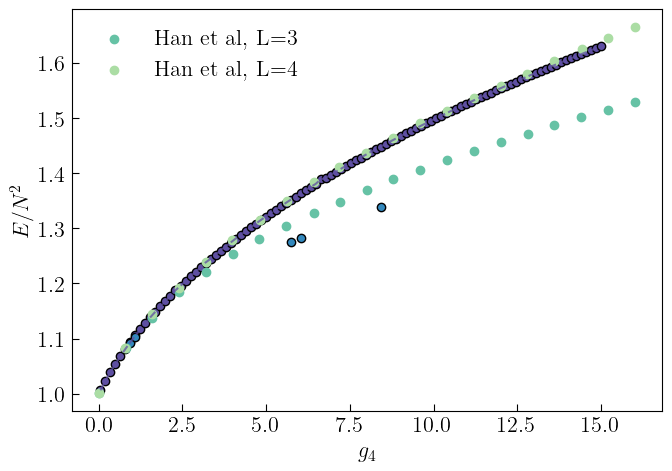

In [4]:
fig, ax = plt.subplots(figsize=(7, 5))

datadir = "data/TwoMatrix_L_3_symmetric"
df = load_data(datadir, names_in_filename=["g4_"])
df["g4"] = [float(df["filename"].iloc[i].split("_")[1][:-5]) for i in range(len(df))]
df.sort_values(by="g4", inplace=True)
ax.scatter(df["g4"], df["energy"], edgecolors="k")
ax.plot(df["g4"], df["energy"], '--', linewidth=1.5, alpha=0.75)

datadir = "data/TwoMatrix_L_3_symmetric_no_penalty"
df = load_data(datadir, names_in_filename=["g4_"], tol=1e-4)
df["g4"] = [float(df["filename"].iloc[i].split("_")[1][:-5]) for i in range(len(df))]
ax.scatter(df["g4"], df["energy"], edgecolors="k")
#ax.plot(df["g4"], df["energy"], '--', linewidth=1.5, alpha=0.75)

# plot g vs E
df_han_hartnoll_fig3a = pd.read_csv("data/data_from_papers/han_hartnoll_data/TwoMatrixFig3a_L_3.csv", header=None, names=["x", "y"])
ax.scatter(2 * df_han_hartnoll_fig3a["x"], 0.5 * df_han_hartnoll_fig3a["y"], label="Han et al, L=3")

df_han_hartnoll_fig3a = pd.read_csv("data/data_from_papers/han_hartnoll_data/TwoMatrixFig3a_L_4.csv", header=None, names=["x", "y"])
ax.scatter(2 * df_han_hartnoll_fig3a["x"], 0.5 * df_han_hartnoll_fig3a["y"], label="Han et al, L=4")

ax.set_xlabel(r"$g_4$")
ax.set_ylabel(r"$E/N^2$")
ax.legend(frameon=False)
plt.tight_layout()
#ax.set_xlim([0.1, 1.4])
plt.show()

Case with $m=0$, can be thought of as a $d=2$ version of Mini-BFSS.

In [5]:
tol = 1e-2

dataframes = []
for method in ["cvxpy", "pytorch"]:
    for L in [3, 4]:
        datadir = f"data/TwoMatrix_L_{L}_symmetric_energy_fixed_g2_0"
        if method == "pytorch":
            datadir += "_pytorch"

        df = load_data(
            datadir=datadir,
            names_in_filename=['energy', "min_x_2"],
            tol=tol,
        )
        if df is not None:
            df["operator_to_minimize"] = "x_2"
            df["L"] = L
            df["method"] = method
            dataframes.append(df)

        df = load_data(
            datadir=datadir,
            names_in_filename=['energy', "neg_x_2"],
            tol=tol,
        )
        if df is not None:
            df["operator_to_minimize"] = "neg_x_2"
            df["L"] = L
            df["method"] = method
            dataframes.append(df)

        df = load_data(
            datadir=datadir,
            names_in_filename=['energy', "min_x_4"],
            tol=tol,
        )
        if df is not None:
            df["operator_to_minimize"] = "x_4"
            df["L"] = L
            df["method"] = method
            dataframes.append(df)

        df = load_data(
            datadir=datadir,
            names_in_filename=['energy', "neg_x_4"],
            tol=tol,
        )
        if df is not None:
            df["operator_to_minimize"] = "neg_x_4"
            df["L"] = L
            df["method"] = method
            dataframes.append(df)


df = pd.concat(dataframes)
df.tail(5)

number of files found: 40
number of loaded data points: 39
max violation of linear constraints:1.2991e-04
max violation of PSD constraints:1.0292e-06
max violation of quadratic constraints:8.2968e-05

number of files found: 40
number of loaded data points: 39
max violation of linear constraints:1.2987e-04
max violation of PSD constraints:5.2990e-05
max violation of quadratic constraints:3.2513e-03

number of files found: 40
number of loaded data points: 39
max violation of linear constraints:1.2837e-04
max violation of PSD constraints:3.2030e-06
max violation of quadratic constraints:8.1911e-05

number of files found: 40
number of loaded data points: 33
max violation of linear constraints:1.2779e-04
max violation of PSD constraints:1.8166e-03
max violation of quadratic constraints:3.4853e-03

number of files found: 26
number of loaded data points: 19
max violation of linear constraints:1.0750e-07
max violation of PSD constraints:4.1982e-06
max violation of quadratic constraints:8.7826e

,solver,prob.status,prob.value,maxiters_cvxpy,||x-init||,violation_of_linear_constraints,min_bootstrap_eigenvalue,max_quad_constraint_violation,quad_constraint_violation_norm,PRNG_seed,...,p_2,p_4,neg_commutator_squared,lagrangian,filename,operator_to_minimize,L,method,num_epochs,operator_loss
32,pytorch,NaN,NaN,NaN,NaN,0.0,9.801706e-07,0.000002,3.067762e-07,NaN,...,3.377770,9.212018,3.377770,0.844442,energy_2.533333_op_to_min_neg_x_4.json,neg_x_4,4,pytorch,30000.0,-5.290804
33,pytorch,NaN,NaN,NaN,NaN,0.0,1.200555e-07,0.000002,2.343998e-07,NaN,...,3.466658,9.640822,3.466658,0.866665,energy_2.6_op_to_min_neg_x_4.json,neg_x_4,4,pytorch,30000.0,-5.350928
24,pytorch,NaN,NaN,NaN,NaN,0.0,6.434717e-08,0.000003,2.482979e-07,NaN,...,3.555546,10.111552,3.555546,0.888886,energy_2.666667_op_to_min_neg_x_4.json,neg_x_4,4,pytorch,30000.0,-5.355898
20,pytorch,NaN,NaN,NaN,NaN,0.0,2.560875e-08,0.000004,1.896142e-07,NaN,...,3.644433,10.602703,3.644433,0.911108,energy_2.733333_op_to_min_neg_x_4.json,neg_x_4,4,pytorch,30000.0,-5.489499
22,pytorch,NaN,NaN,NaN,NaN,0.0,2.401032e-08,0.000005,2.394200e-07,NaN,...,3.733321,11.089637,3.733321,0.933330,energy_2.8_op_to_min_neg_x_4.json,neg_x_4,4,pytorch,30000.0,-5.459619


In [6]:
len(df[df["L"] == 3]), len(df[df["L"] == 4])

(302, 213)

In [7]:
# test that H = K + V, implying that K, V can be correctly extracted
assert np.allclose(df["energy"], df["p_2"]/2 + df["neg_commutator_squared"]/4)

df["energy"] = np.round(df["energy"], decimals=8)
df.sort_values("energy", inplace=True)

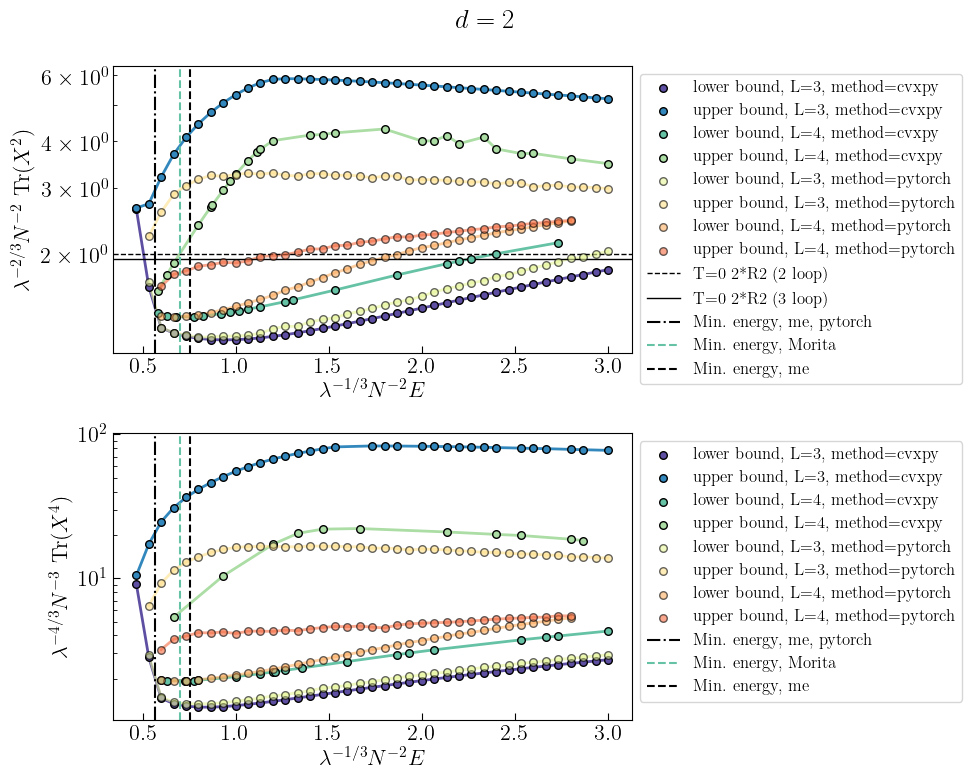

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(10, 2*4))

ax = axes[0]
for method in ["cvxpy", "pytorch"]:
    for L in [3, 4]:
        if method == 'pytorch':
            alpha = 0.6
        else:
            alpha = 1.0

        operator_to_minimize = "x_2"
        df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == L) & (df["method"] == method)]
        if len(df_tmp) > 0:
            ax.scatter(df_tmp["energy"], df_tmp[operator_to_minimize], edgecolor='k', zorder=10, s=30, label=f'lower bound, L={L}, method={method}', alpha=alpha)
            ax.plot(df_tmp["energy"], df_tmp[operator_to_minimize], alpha=alpha)

        operator_to_minimize = "neg_x_2"
        df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == L) & (df["method"] == method)]
        if len(df_tmp) > 0:
            ax.scatter(df_tmp["energy"], df_tmp["x_2"], edgecolor='k', zorder=10, s=30, label=f'upper bound, L={L}, method={method}', alpha=alpha)
            ax.plot(df_tmp["energy"], df_tmp["x_2"], alpha=alpha)

ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
ax.axhline(2*Morita_R_squared(d=2, loop=2), linestyle='--', color='k', linewidth=1, label='T=0 2*R2 (2 loop)')
ax.axhline(2*Morita_R_squared(d=2, loop=3), linestyle='-', color='k', linewidth=1, label='T=0 2*R2 (3 loop)')
ax.set_yscale('log')

ax = axes[1]
for method in ["cvxpy", "pytorch"]:
    for L in [3, 4]:
        if method == 'pytorch':
            alpha = 0.6
        else:
            alpha = 1.0

        operator_to_minimize = "x_4"
        df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == L) & (df["method"] == method)]
        if len(df_tmp) > 0:
            ax.scatter(df_tmp["energy"], df_tmp[operator_to_minimize], edgecolor='k', zorder=10, s=30, label=f'lower bound, L={L}, method={method}', alpha=alpha)
            ax.plot(df_tmp["energy"], df_tmp[operator_to_minimize], alpha=alpha)

        operator_to_minimize = "neg_x_4"
        df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == L) & (df["method"] == method)]
        if len(df_tmp) > 0:
            ax.scatter(df_tmp["energy"], df_tmp["x_4"], edgecolor='k', zorder=10, s=30, label=f'upper bound, L={L}, method={method}', alpha=alpha)
            ax.plot(df_tmp["energy"], df_tmp["x_4"], alpha=alpha)

#energy = np.linspace(0.4, 3.0, 40)
#ax.plot(energy, lin_lower_bound_x4_bosonic_only(energy, d=2), label="Lin", color='k', linestyle='--', linewidth=1)

ax.legend(fontsize=12, bbox_to_anchor=(1,1))
ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-4/3} N^{-3}$ Tr$(X^4)$")
ax.set_yscale('log')

for ax in axes:
    ax.axvline(0.5662, linestyle='-.', color='k', linewidth=1.5, label='Min. energy, me, pytorch')
    ax.axvline(0.7, linestyle='--', color=colors[2], linewidth=1.5, label='Min. energy, Morita')
    ax.axvline(0.7568, linestyle='--', color='k', linewidth=1.5, label='Min. energy, me')
    ax.legend(fontsize=12, bbox_to_anchor=(1,1))

plt.suptitle(r"$d=2$")
plt.tight_layout()
plt.show()

The minimum energy should be 0.7 in my units (1.4 in HHK's)

In [9]:
for operator_to_minimize in ["x_2", "neg_x_2", "x_4", "neg_x_4"]:
    print(df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == 3)]["energy"].min())

0.46657401
0.46657406
0.46657528
0.46657518


In [11]:
(2/3) * 0.7

0.4666666666666666

In [12]:
for operator_to_minimize in ["x_2", "neg_x_2", "x_4", "neg_x_4"]:
    print(df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == 4)]["energy"].min())

0.582759
0.582759
0.59999999
0.60000043


In [14]:
0.582759 / 0.7

0.8325128571428573

In [15]:
1/1.2

0.8333333333333334

## BFSS

In [ ]:
tol = 1e-3
delete_param = False
dataframes = []
for method in ["cvxpy", "pytorch"]:
    for L in [3]:
        datadir = f"data/MiniBFSSx_L_{L}_symmetric_energy_fixed"
        if method == "pytorch":
            datadir += "_pytorch"

        df = load_data(
            datadir=datadir,
            names_in_filename=['energy', "min_x_2"],
            tol=tol,
            delete_param=delete_param,
        )
        if df is not None:
            df["operator_to_minimize"] = "x_2"
            df["L"] = L
            df["method"] = method
            dataframes.append(df)

        df = load_data(
            datadir=datadir,
            names_in_filename=['energy', "neg_x_2"],
            tol=tol,
            delete_param=delete_param,
        )
        if df is not None:
            df["operator_to_minimize"] = "neg_x_2"
            df["L"] = L
            df["method"] = method
            dataframes.append(df)

        df = load_data(
            datadir=datadir,
            names_in_filename=['energy', "min_x_4"],
            tol=tol,
            delete_param=delete_param,
        )
        if df is not None:
            df["operator_to_minimize"] = "x_4"
            df["L"] = L
            df["method"] = method
            dataframes.append(df)

        df = load_data(
            datadir=datadir,
            names_in_filename=['energy', "neg_x_4"],
            tol=tol,
            delete_param=delete_param,
        )
        if df is not None:
            df["operator_to_minimize"] = "neg_x_4"
            df["L"] = L
            df["method"] = method
            dataframes.append(df)


df = pd.concat(dataframes)
df.tail(5)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 2*4))

ax = axes[0]
for method in ["cvxpy", "pytorch"]:
    if method == 'pytorch':
        alpha = 0.6
    else:
        alpha = 1.0

    for L in [3]: #, 4]:
        operator_to_minimize = "x_2"
        df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == L) & (df["method"] == method)]
        if len(df_tmp) > 0:
            ax.scatter(df_tmp["energy"], df_tmp[operator_to_minimize], edgecolor='k', zorder=10, s=30, label=f'lower bound, L={L}, method={method}')
            ax.plot(df_tmp["energy"], df_tmp[operator_to_minimize], alpha=alpha)

        operator_to_minimize = "neg_x_2"
        df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == L) & (df["method"] == method)]
        if len(df_tmp) > 0:
            ax.scatter(df_tmp["energy"], df_tmp["x_2"], edgecolor='k', zorder=10, s=30, label=f'upper bound, L={L}, method={method}')
            ax.plot(df_tmp["energy"], df_tmp["x_2"], alpha=alpha)

ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-2/3} N^{-2}$ Tr$(X^2)$")
#ax.axhline(Morita_R_squared(d=2, loop=2), linestyle='--', color='k', linewidth=1, label='T=0 2*R2 (2 loop)')
#ax.axhline(Morita_R_squared(d=2, loop=3), linestyle='-', color='k', linewidth=1, label='T=0 2*R2 (3 loop)')
#ax.set_yscale('log')

ax = axes[1]
for method in ["cvxpy", "pytorch"]:
    if method == 'pytorch':
        alpha = 0.6
    else:
        alpha = 1.0

    for L in [3]: #, 4]:
        operator_to_minimize = "x_4"
        df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == L) & (df["method"] == method)]
        if len(df_tmp) > 0:
            ax.scatter(df_tmp["energy"], df_tmp[operator_to_minimize], edgecolor='k', zorder=10, s=30, label=f'lower bound, L={L}, method={method}')
            ax.plot(df_tmp["energy"], df_tmp[operator_to_minimize], alpha=alpha)

        operator_to_minimize = "neg_x_4"
        df_tmp = df[(df["operator_to_minimize"] == operator_to_minimize) & (df["L"] == L) & (df["method"] == method)]
        if len(df_tmp) > 0:
            ax.scatter(df_tmp["energy"], df_tmp["x_4"], edgecolor='k', zorder=10, s=30, label=f'upper bound, L={L}, method={method}')
            ax.plot(df_tmp["energy"], df_tmp["x_4"], alpha=alpha)

energy = np.linspace(0.4, 3.0, 40)
ax.plot(energy, lin_lower_bound_x4_bosonic_only(energy, d=3), label="Lin", color='k', linestyle='--', linewidth=1)

ax.set_xlabel(r"$\lambda^{-1/3} N^{-2} E$")
ax.set_ylabel(r"$\lambda^{-4/3} N^{-3}$ Tr$(X^4)$")
ax.set_yscale('log')

for ax in axes:
    #ax.axvline(0.5662, linestyle='-.', color='k', linewidth=1.5, label='Min. energy, me, pytorch')
    ax.axvline(0.7, linestyle='--', color=colors[2], linewidth=1.5, label='Min. energy, Morita')
    #ax.axvline(0.7568, linestyle='--', color='k', linewidth=1.5, label='Min. energy, me')
    ax.legend(fontsize=12, bbox_to_anchor=(1,1))

plt.suptitle(r"$d=3$ BFSS")
plt.tight_layout()
plt.show()

In [ ]:
lin_lower_bound_x4_bosonic_only(energy, d=3)